In [1]:
# using GuSTO"
using JLD2, FileIO
using BenchmarkTools
include("../src/GuSTO.jl")

┌ Info: Precompiling BulletCollision [b3564421-7037-56b3-90f4-5b7f54e2ead3]
└ @ Base loading.jl:1192


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/75259c676c4c94b02ca26a89265c53e5a244a54a-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/75259c676c4c94b02ca26a89265c53e5a244a54a-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

Forest

In [2]:
function setUpEnvironmentSphereObstacles()
    env = ISSCorner();
    add_obstacles!(env)
    return env
end

setUpEnvironmentSphereObstacles (generic function with 1 method)

In [7]:
function setUpProblemAllParams(N, r_init, r_goal, q_init, q_goal, robot, model, env, tf_guess)
    goal_set = GoalSet()
    addGoals!(goal_set, r_init, r_goal, q_init, q_goal, tf_guess)
    x_init = [r_init; zeros(3); q_init; zeros(3)]
    PD = ProblemDefinition(robot, model, env, x_init, goal_set);
    TOP = TrajectoryOptimizationProblem(PD, N, tf_guess, fixed_final_time=true)
    TOSgusto = TrajectoryOptimizationSolution(TOP)
    return TOP, TOSgusto
end

setUpProblemAllParams (generic function with 1 method)

In [8]:
function addGoals!(goal_set, r_init, r_goal, q_init, q_goal, tf_guess)
    q_goal = q_goal/norm(q_goal)
    x_init = [r_init; zeros(3); q_init; zeros(3)]
    v_goal = zeros(3)
    ω_goal = zeros(3)

    x_goal = [r_goal; v_goal; q_goal; ω_goal]
    # add_goal!(goal_set, Goal(PointGoal(x_goal), tf_guess, model))

    ε = 1e-4
    add_goal!(goal_set, Goal(PointGoal(r_goal), tf_guess, 1:3))
    add_goal!(goal_set, Goal(PointGoal(v_goal), tf_guess, 4:6))
    add_goal!(goal_set, Goal(BoxGoal(q_goal.-ε, q_goal.+ε), tf_guess, 7:10))
    # add_goal!(goal_set, Goal(PointGoal(q_goal), tf_guess, 7:10))
    add_goal!(goal_set, Goal(PointGoal(ω_goal), tf_guess, 11:13))
end

addGoals! (generic function with 1 method)

In [9]:
function createTrainingInputAndOutput(traj_X_vec, traj_U_vec, ω_vec, Δ_vec, dual_vec = nothing)
    X_row = hcat((map(a -> a[:], traj_X_vec))...)'
    U_row = hcat((map(a -> a[:], traj_U_vec))...)'
    if dual_vec != nothing
        dual_row = hcat((map(a -> a[:], dual_vec))...)'
    end
#     @show(size(ω_vec))
#     @show(size(X_row))
    if dual_vec == nothing
        train_input = hcat(X_row, U_row, ω_vec, Δ_vec)[1:end-1,:]
    else
        train_input = hcat(X_row, U_row, ω_vec, Δ_vec, dual_row)[1:end-1,:]
    end

    diff_X = traj_X_vec[2:end]-traj_X_vec[1:end-1]
    diff_U = traj_U_vec[2:end]-traj_U_vec[1:end-1]
    diff_X_row = hcat((map(a -> a[:], diff_X))...)'
    diff_U_row = hcat((map(a -> a[:], diff_U))...)'

    if dual_vec == nothing
        train_output = hcat(diff_X_row, diff_U_row)
    else
        train_output = hcat(diff_X_row, diff_U_row, dual_row[2:end, :])
    end
    
    if size(train_input,1) != size(train_output,1)
        println("ERROR: train input and output have different # of rows")
    end
    if size(train_input,2) - 2 != size(train_output,2)
        println("ERROR: each row of train input should 2 elements more than output")
    end
    
    return train_input, train_output
    
end

createTrainingInputAndOutput (generic function with 2 methods)

# Time one iteration of GuSTO

In [36]:
time_start = time_ns()

env = setUpEnvironmentSphereObstacles()
N = 50
robot = Astrobee3D()
model = AstrobeeSE3Manifold()
tf_guess = 10.

# Pick the init and goal positions
# Small corner maneuver
r_init = [11.2; -0.8; 5.6]
r_goal = [10.9; 3.0; 5.0]
q_init = [1.; 0.; 0.; 0.]
# q_goal = [1.; 0.; 0.; 0.]
q_goal = [1.; 0.5; 0.5; 0.5]
# q_goal = [1.; 0.2; 0.3; 0.4]


max_iter = 10

TOP, TOSgusto = setUpProblemAllParams(N, r_init, r_goal, q_init, q_goal, robot, model, env, tf_guess)
traj_init = init_traj_straightline(TOP)

traj_X_vec = [traj_init.X] 
traj_U_vec = [traj_init.U]
traj_X_vec_first_only = [traj_init.X]
traj_U_vec_first_only = [traj_init.U]
dual_vec = [zeros(13)]

gusto_setup_time = (time_ns() - time_start)/10^9
println("Setup time $gusto_setup_time")

# Solve one step at a time with IPOPT
time_start = time_ns()
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
gusto_solve_time = (time_ns() - time_start)/10^9
println("Setup time $gusto_solve_time")

repTime = TOSgusto.SCPS.total_time
println("Time reported $repTime")



Setup time 0.023373507
Setup time 0.565055577
Time reported 0.53153665


In [33]:
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.total_time
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.convergence_measure
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.J_true
@show TOSgusto.SCPS.dual
;

(TOSgusto.SCPS).converged = false
(TOSgusto.SCPS).iterations = 1
(TOSgusto.SCPS).total_time = 0.531262319
(TOSgusto.SCPS).accept_solution = Bool[true, true]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(TOSgusto.SCPS).convergence_measure = [0.0, 0.0701819]
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 5.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [1000.0, 1000.0]
(TOSgusto.SCPS).J_true = Any[0.0, 62.3081]
(TOSgusto.SCPS).dual = [-1.90918, 111.071, -22.2502, -31.7574, 725.764, -136.02, -0.000309332, 0.000486269, 0.000486269, 0.000486269, 0.00121421, 0.00121421, 0.00121421]


# Time all iterations of GuSTO

In [38]:
time_start = time_ns()

env = setUpEnvironmentSphereObstacles()
N = 50
robot = Astrobee3D()
model = AstrobeeSE3Manifold()
tf_guess = 10.

# Pick the init and goal positions
# Small corner maneuver
r_init = [11.2; -0.8; 5.6]
r_goal = [10.9; 3.0; 5.0]
q_init = [1.; 0.; 0.; 0.]
# q_goal = [1.; 0.; 0.; 0.]
q_goal = [1.; 0.5; 0.5; 0.5]
# q_goal = [1.; 0.2; 0.3; 0.4]


max_iter = 10

TOP, TOSgusto = setUpProblemAllParams(N, r_init, r_goal, q_init, q_goal, robot, model, env, tf_guess)
traj_init = init_traj_straightline(TOP)

traj_X_vec = [traj_init.X] 
traj_U_vec = [traj_init.U]
traj_X_vec_first_only = [traj_init.X]
traj_U_vec_first_only = [traj_init.U]
dual_vec = [zeros(13)]

gusto_setup_time = (time_ns() - time_start)/10^9
println("Setup time $gusto_setup_time")

# Solve one step at a time with IPOPT
time_start = time_ns()
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=100, print_level=0);
gusto_solve_time = (time_ns() - time_start)/10^9
println("Solve time $gusto_solve_time")

repTime = TOSgusto.SCPS.total_time
println("Time reported $repTime")



Setup time 0.019180671
Solve time 4.723032807
Time reported 4.704860932


In [27]:
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.total_time
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.convergence_measure
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.J_true
@show TOSgusto.SCPS.dual
;

(TOSgusto.SCPS).converged = true
(TOSgusto.SCPS).iterations = 7
(TOSgusto.SCPS).total_time = 5.047244804999999
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true, true, true, true, true]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).convergence_measure = [0.0, 0.0701819, 0.00396256, 0.00304667, 0.0110116, 0.000427625, 1.40355e-5, 5.83572e-7]
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 5.0, 25.0, 125.0, 125.0, 125.0, 125.0, 125.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
(TOSgusto.SCPS).J_true = Any[0.0, 62.3081, 63.0066, 64.4434, 99.1266, 98.8741, 98.8772, 98.8775]
(TOSgusto.SCPS).dual = [-1.28541, 655.519, -133.94, -10.2244, 3295.78, -

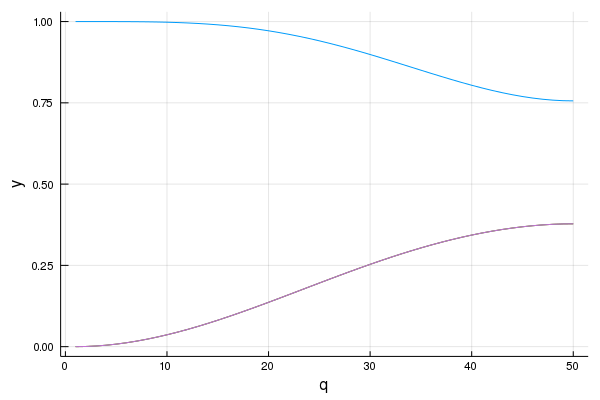

In [28]:
using Plots
gr(fmt=:png)
plot()
for i = 7:10
    plot!([collect(1:N)],[TOSgusto.SCPS.traj.X[i,:]],
        xlabel = "q",
        ylabel = "y",
        legend = :none)
end
plot!()

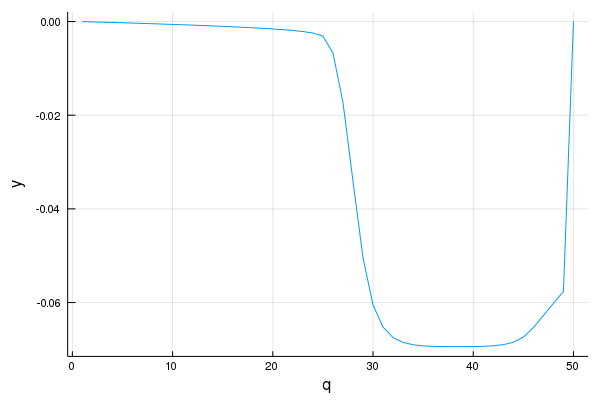

In [29]:
gr(fmt=:png)
plot()
plot!([collect(1:N)],[TOSgusto.SCPS.traj.X[4,:]],
    xlabel = "q",
    ylabel = "y",
    legend = :none)

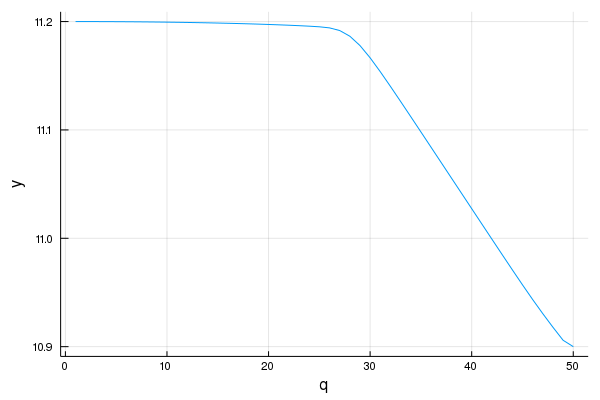

In [30]:
gr(fmt=:png)
plot()
plot!([collect(1:N)],[TOSgusto.SCPS.traj.X[1,:]],
    xlabel = "q",
    ylabel = "y",
    legend = :none)

In [31]:
using AstrobeeRobot

# Animate Astrobee trajectory
vis = Visualizer()
delete!(vis)

vis[:goal]
for (idx,obs) in enumerate(env.keepout_zones)
    setobject!(vis[:goal][:goal], 
        Object(HyperSphere(Point3f0(x_goal[1:3]), 0.1f0),
            MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))
end

vis[:workspace]
for (idx,ws) in enumerate(env.keepin_zones)
    if idx in (5,8)
        setobject!(vis[:workspace][Symbol(string("ws",idx))],
            Object(ws, MeshBasicMaterial(color=RGBA(0.95,0.93,0.26,0.3), depthWrite=false)))
    else
        setobject!(vis[:workspace][Symbol(string("ws",idx))],
            Object(ws, MeshBasicMaterial(color=RGBA(0.95,0.93,0.26,0.3))))
    end
end

vis[:obstacle]
for (idx,ws) in enumerate(env.obstacle_set)
    setobject!(vis[:workspace][Symbol(string("ws",idx+length(env.keepin_zones)))],
        Object(ws,MeshBasicMaterial(color=RGBA(0.95,0.26,0.26,0.3))))
end

ab = Astrobee()
mvis = MechanismVisualizer(
    ab.mechanism,
    URDFVisuals(AstrobeeRobot.urdfpath(), package_path=[dirname(dirname(AstrobeeRobot.urdfpath()))]),
    vis);

speed_factor = 3

Qs = Vector{Vector{Float64}}()
for k in 1:speed_factor:N
#     q = [quat_inv(TOS_SCP.SCPS.traj.X[7:10,k]); TOS_SCP.SCPS.traj.X[1:3,k]]
    q = [quat_inv(TOSgusto.SCPS.traj.X[7:10,k]); TOSgusto.SCPS.traj.X[1:3,k]]
    push!(Qs,q)
end

trans = Translation(14., -1., 7.)
rot = LinearMap(RotZ(-0.6)) ∘ LinearMap(RotY(-0.2))
settransform!(vis["/Cameras/default"], trans ∘ rot)
setprop!(vis["/Cameras/default/rotated/<object>"], "zoom", 1.9)
setprop!(vis["/Cameras/default/rotated/<object>"], "near", 0.05)

sleep(3)
setanimation!(mvis,1:length(Qs),Qs)

plot_in_cell = false
plot_in_cell ? IJuliaCell(vis) : open(vis)

UndefVarError: UndefVarError: x_goal not defined